In [4]:
import tensorflow as tf
import numpy as np
import glob
import os
import cv2
from PIL import Image , ImageOps

In [26]:
dir_path = "/content/drive/MyDrive/Deep Learning/Lab Assignment - 20BAI10003/Semantic Segmentation Algorithms/cityscape_images"

# list all the files in the directory
file_list = os.listdir(dir_path)

# print the list of files
print(file_list)

['153.jpg', '152.jpg', '150.jpg', '148.jpg', '149.jpg', '147.jpg', '15.jpg', '151.jpg', '146.jpg', '145.jpg', '144.jpg', '142.jpg', '143.jpg', '141.jpg', '139.jpg', '140.jpg', '138.jpg', '14.jpg', '137.jpg', '136.jpg', '135.jpg', '130.jpg', '133.jpg', '131.jpg', '132.jpg', '134.jpg', '13.jpg', '129.jpg', '128.jpg', '127.jpg', '126.jpg', '121.jpg', '125.jpg', '124.jpg', '122.jpg', '123.jpg', '12.jpg', '120.jpg', '119.jpg', '118.jpg', '117.jpg', '110.jpg', '116.jpg', '114.jpg', '115.jpg', '111.jpg', '113.jpg', '112.jpg', '109.jpg', '11.jpg', '108.jpg', '102.jpg', '101.jpg', '106.jpg', '107.jpg', '105.jpg', '104.jpg', '103.jpg', '100.jpg', '10.jpg', '1.jpg', '21.jpg', '209.jpg', '208.jpg', '207.jpg', '206.jpg', '203.jpg', '205.jpg', '202.jpg', '204.jpg', '201.jpg', '200.jpg', '20.jpg', '2.jpg', '199.jpg', '195.jpg', '193.jpg', '198.jpg', '197.jpg', '196.jpg', '194.jpg', '191.jpg', '192.jpg', '19.jpg', '190.jpg', '184.jpg', '189.jpg', '187.jpg', '183.jpg', '188.jpg', '185.jpg', '186.jpg', 

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x = list()
y = list()

num_images = 400

image_dir = 'cityscape_images/images'
image_filenames = os.listdir( image_dir )
for filename in image_filenames[ 0 : 100 ]:
	image = Image \
		.open(os.path.join( image_dir, filename))
	x.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
	y.append(np.asarray( ImageOps.crop(image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))

x = np.array( x ) / 255
y = np.array( y )

train_features, test_features, train_labels, test_labels = train_test_split(np.array(x), np.array(y),
																					test_size=0.4)

def binarize( pixel ):
    if np.array_equal( pixel , [ 128 , 63 , 127 ]):
        return np.array( [ 1 ] )
    else :
        return np.array( [ 0 ] )

train_labels = np.apply_along_axis( binarize , axis=3 , arr=train_labels ) 
test_labels = np.apply_along_axis( binarize , axis=3 , arr=test_labels ) 

batch_size = 5

train_dataset = tf.data.Dataset.from_tensor_slices( ( train_features , train_labels ) )
train_dataset = train_dataset.shuffle( 1024 ).batch( batch_size )
test_dataset = tf.data.Dataset.from_tensor_slices( ( test_features , test_labels ) )
test_dataset = test_dataset.shuffle( 1024 ).batch( batch_size )


In [12]:
relu_alpha = 0.2

dropout_rate = 0.5

padding = 'SAME'

def conv2d_down( inputs , filters , stride_size ):
    out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_down( inputs , pool_size , stride_size ):
    return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

def conv2d_up( inputs , filters , stride_size , output_shape ):
    out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_up( inputs , size ):
    in_dimen = tf.shape( inputs )[ 1 ]
    out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
    return tf.image.resize( inputs , [ out_dimen , out_dimen ] , method='nearest' )

In [13]:
initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True )

shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 384 ],
    [ 3 , 3 , 128 , 128 ],

    [ 3 , 3 , 64 , 192 ],
    [ 3 , 3 , 64 , 64 ],

    [ 3 , 3 , 32 , 96 ],
    [ 3 , 3 , 32 , 32 ],

    [ 3 , 3 , 16 , 48 ],
    [ 3 , 3 , 16 , 16 ],

    [ 1 , 1 , 16 , 1 ],
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
def model( x ) :
    batch_size = tf.shape( x )[0]
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d_down( x , weights[ 0 ] , stride_size=1 ) 
    c1 = conv2d_down( c1 , weights[ 1 ] , stride_size=1 ) 
    p1 = maxpool_down( c1 , pool_size=2 , stride_size=2 )
    
    c2 = conv2d_down( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d_down( c2 , weights[ 3 ] , stride_size=1 ) 
    p2 = maxpool_down( c2 , pool_size=2 , stride_size=2 )
    
    c3 = conv2d_down( p2 , weights[ 4 ] , stride_size=1 ) 
    c3 = conv2d_down( c3 , weights[ 5 ] , stride_size=1 ) 
    p3 = maxpool_down( c3 , pool_size=2 , stride_size=2 )
    
    c4 = conv2d_down( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d_down( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool_down( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d_down( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d_down( c5 , weights[ 9 ] , stride_size=1 ) 
        
    p5 = maxpool_up( c5 , 2 )
    concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
    c6 = conv2d_up( concat_1 , weights[ 10 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )
    c6 = conv2d_up( c6 , weights[ 11 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )  

    p6 = maxpool_up( c6 , 2 )
    concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
    c7 = conv2d_up( concat_2 , weights[ 12 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )
    c7 = conv2d_up( c7 , weights[ 13 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )  

    p7 = maxpool_up( c7 , 2 )
    concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
    c8 = conv2d_up( concat_3 , weights[ 14 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )
    c8 = conv2d_up( c8 , weights[ 15 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )   

    p8 = maxpool_up( c8 , 2 )
    concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
    c9 = conv2d_up( concat_4 , weights[ 16 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )
    c9 = conv2d_up( c9 , weights[ 17 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )   

    output = tf.nn.conv2d( c9 , weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding=padding ) 
    outputs = tf.nn.sigmoid( output ) 
    return outputs

In [15]:
def loss( pred , target ):
    return tf.losses.binary_crossentropy( target , pred )

learning_rate = "0.001"
optimizer = tf.optimizers.Adam( learning_rate=float( learning_rate ) )

def train( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        current_loss = loss( model( inputs ), outputs)
    grads = tape.gradient( current_loss , weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    return tf.reduce_mean( current_loss )

In [18]:
import datetime

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer( logdir + "/metrics")
file_writer.set_as_default()

num_epochs = 25

for e in range( num_epochs ):
    print( 'Epoch {} out of {} {}'.format( e + 1 , num_epochs , '--' * 50 ) )
    for features in train_dataset:
        image , label = features
        summ_loss = train( model , image , label )
        tf.summary.scalar('loss', data=summ_loss, step=e )

Epoch 1 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 2 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 3 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 4 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 5 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 6 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 7 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 8 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 9 out of 25 ------------------------------

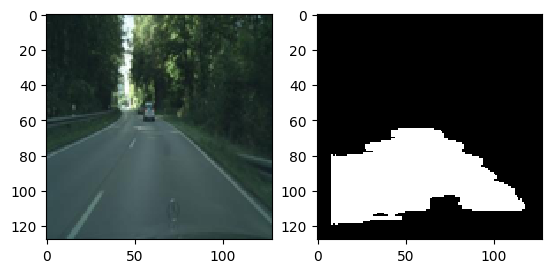

In [24]:
import matplotlib.pyplot as plt

input_image = test_features[0:1]
pred = model( input_image ).numpy()
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if pred[ 0 , x , y ] > 0.5:
            image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            image[ x , y ] = [ 0, 0, 0]

def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()

show_images( [ test_features[0] , image ] )